<h1 align='center'><b><font color='indianred'></p>Spam Detection HW</b></h1>

<font color = 'indianred' size = 4 >**Read complete instructions before starting the HW** </font>


# <font color='indianred'> **Q1: Load the dataset  (1 Point)**

- For this Hw you will usespam dataset from kaggle which can be found from [this](https://www.kaggle.com/uciml/sms-spam-collection-dataset) link. You can download this data and either upload it in google drive or in colab workspace. Load the data in pandas dataframe.

- There are only two useful columns. These columns are related to (1) label (ham and spam) and the (2) text of email.

- Rename columns as label and message

- Find the %  ham and spam in the data.





In [ ]:
#Load Dataset

import pandas as pd

df = pd.read_csv('spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
#Rename columns

df = df[['v1', 'v2']]
df.columns = ['label', 'message']
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


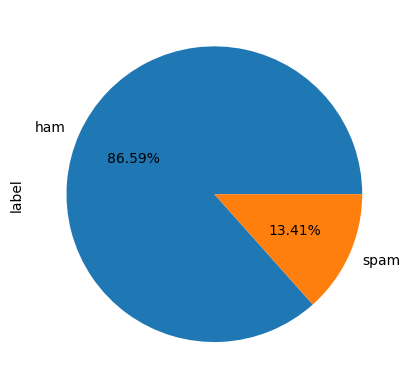

In [ ]:
# % of ham and spam

import matplotlib.pyplot as plt
df['label'].value_counts().plot.pie(autopct='%2.2f%%')
plt.show()

In [ ]:
#Convert to Binary if spam then 1, else 0 to process ahead

df['label'] = df['label'].map(lambda x: 1 if x == 'spam' else 0) # converting target labels to binary (0,1)

# <font color='indianred'> **Q2 : Provide the metric for evaluating model (1 Point)**</font>

As you will notice, the  data is highly imbalanced (most messages are labelled as ham and only few are labelled as spam). Always predicting ham will give us very good accuracy (close to 90%). So you need to choose a different metric.

Task: Provde the metric you will choose to evaluate your model. Explain why this is an appropriate metric for this case.

<font color="teal">**I will be using ROC AUC score as the metric for this case.**

Why:

ROC AUC (Receiver Operating Characteristic Area Under the Curve) is ideal for imbalanced datasets
because it evaluates a classifier's ability to rank instances across all possible thresholds,
making it insensitive to class imbalance. It provides a comprehensive view of model performance,
considering trade-offs between true positive and false positive rates. Additionally,
it's interpretable, robust to class skew, and applicable to multi-class classification.
Overall, it's a reliable metric for assessing classifier performance in imbalanced datasets.
</font>

# <font color='indianred'> **Q3 : Classification Pipelines (18 Points)**</font>

In the previous lectures you learned Data processing, Featurization such as CountVectorizer, TFIDFVectorizer, and also Feature Engineering.
* You will now use folllowing methods to create fearures which you can use in your model.

    1. Sparse Embeddings (TF-IDF) (6 Points)
    2. Feature Engineering (see examples below) (6 Points)
    3. Sparse Embeddings (TF-IDF) + Feature Engineering (6 Points)

**Approach:**

<font color='indianred'> ****Use a smaller subset of dataset (e.g. 5-10 %) to evaluate the three pipelines . Based on your analysis (e.g. model score, learning curves) , choose one pipeline from the three. Provde your rational for choosing the pipleine. Train only the final pipeline on randomly selected larger subset (e.g. 40%) of the data.** </font>

**Requirements:**

1. You can use any ML model (Logistic Regression, XgBoost) for the classification. You will need to tune the **model for imbalanced dataset** (The link on XGBoost tutorial for imbalanced data: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/).

2. For feature engineering, you can choose from the examples below. You do not  have to use all of them. You can add other featues as well. Think about what faetures can distinguish a spam from a regular email. Some examples :

>> Count of following  (Words, characters, digits, exclamation marks, numbers, Nouns, ProperNouns, AUX, VERBS, Adjectives, named entities, spelling mistakes (see the link on how to get spelling mistakes https://pypi.org/project/pyspellchecker/).

3. For Sparse embeddings you will use **tfidf vectorization**. You need to choose appopriate parameters e.g. min_df, max_df, max_faetures, n-grams etc.).

4. Think carefully about the pre-processing you will do.

Tip: <font color = 'indianred'>**Using GridSearch for hyperparameter tuning might take a lot of time. Try using RandomizedSearch.**</font> You can also explore faster implementation of Gridsearch and RandomizedSearch in sklearn:

1. [Halving Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html?highlight=halving#sklearn.model_selection.HalvingGridSearchCV)

2. [HalvingRandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html?highlight=halving#sklearn.model_selection.HalvingRandomSearchCV)





## **Part 1: Random 10% data for testing the 3 pipelines**

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from plot_learning_curve import plot_learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from FeaturizerSpacy import ManualFeatures
from sklearn.pipeline import Pipeline
import CustomPreprocessorSpacy as cp
from scipy.sparse import csr_matrix
from xgboost import XGBClassifier
from pathlib import Path
import numpy as np
import joblib

In [ ]:
#Small subset sampling
df_ = df.sample(frac=0.1, replace=True, random_state=1)

In [ ]:
#Extracting values of column message into X and label into Y
X, y = df_['message'].values, df_['label'].values

In [ ]:
#Make base directories
base_folder = Path('./')
data_folder = base_folder/'datasets/'
model_folder = base_folder/'models/'

model_folder.mkdir(exist_ok=True, parents=True)
data_folder.mkdir(exist_ok=True, parents=True)

In [ ]:
# Splitting the data into train test splits with test as 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4, stratify=y)

# Approach 1: Sparse Embeddings (TFIDF)

In [ ]:
# Cleaning the text data in X_train and X_test
X_train_cleaned_bow = cp.SpacyPreprocessor(model='en_core_web_sm', batch_size=500, remove_email=False,
                                           remove_url=False, remove_punct=False).transform(X_train)
X_test_cleaned_bow = cp.SpacyPreprocessor(model='en_core_web_sm', batch_size=500, remove_email=False,
                                          remove_url=False, remove_punct=False).transform(X_test)

# save  this to a file
file_X_train_cleaned_bow = data_folder / 'x_train_cleaned_bow_small.pkl'
joblib.dump(X_train_cleaned_bow, file_X_train_cleaned_bow)

# save  this to a file
file_X_test_cleaned_bow = data_folder / 'x_test_cleaned_bow_small.pkl'
joblib.dump(X_test_cleaned_bow, file_X_test_cleaned_bow)

/content/CustomPreprocessorSpacy.py:83: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


['datasets/x_test_cleaned_bow_small.pkl']

In [ ]:
#Using TFIDF and XFBClassifier
classifier_1 = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
    ('classifier', XGBClassifier())])

# classifier_1 = Pipeline([
#     ('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
#     ('classifier', LogisticRegression(max_iter=10000)),])

In [ ]:
#Param Grid
params_classifier_1 = {
                      'vectorizer__max_features': [500, 1000, 1500, 2000, 2500],
                      'vectorizer__min_df': [1, 5, 10],  # Minimum number of documents a word must be present in
                      'vectorizer__max_df': [0.5, 0.75, 1.0],  # Maximum proportion of documents a word can be present in
                      'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],  # Unigrams, Bigrams, or both
                      'classifier__n_estimators': [100, 200, 300],  # Number of trees in the forest for RandomForestClassifier
                      'classifier__max_depth': [3, 4, 5]  # Maximum depth of the trees for RandomForestClassifier
                      }

# params_classifier_1 = {'vectorizer__max_features': [1000, 2000, 5000],
#                        'classifier__C': [1, 10, 100,]}

In [ ]:
#Defining RandomSearch CV Classifier
randomsearchCV_classifier_1 = RandomizedSearchCV(estimator=classifier_1, param_distributions=params_classifier_1, cv=5, scoring='roc_auc')

In [ ]:
#Fit RandomSearch CV on train data
%%time
randomsearchCV_classifier_1.fit(X_train_cleaned_bow, y_train)

CPU times: user 5.71 s, sys: 83.7 ms, total: 5.79 s
Wall time: 5.92 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vectorizer',
                                              TfidfVectorizer(token_pattern='[\\S]+')),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=...
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=None, ...))]),
                   param_distributions={'classifier__max_depth': [3, 4, 5],
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'vectorizer__max_df': [0.5, 0.75, 1.0],
                                        'vectorizer__max_features': [500, 1000,
                                                                     1500, 2000,
                                                                     2500],
                                        'vectorizer__min_df': [1, 5, 10],
                                        'vectorizer__ngram_range': [(1, 1),
                                                                    (1, 2),
                                                                    (2, 2)]},
                   scoring='roc_auc')

In [ ]:
#Validation best scores,parameters and estimators
print(f'Best cross-validation score: {randomsearchCV_classifier_1.best_score_:.2f}')
print("\nBest parameters: ", randomsearchCV_classifier_1.best_params_)
print("\nBest estimator: ", randomsearchCV_classifier_1.best_estimator_)

Best cross-validation score: 0.91

Best parameters:  {'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 5, 'vectorizer__max_features': 500, 'vectorizer__max_df': 0.5, 'classifier__n_estimators': 100, 'classifier__max_depth': 3}

Best estimator:  Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.5, max_features=500, min_df=5,
                                 ngram_range=(1, 2), token_pattern='[\\S]+')),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feat...grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learni

In [ ]:
file_best_estimator_pipeline1_round1 = model_folder / \
    'pipeline1_round1_best_estimator.pkl'
file_complete_grid_pipeline1_round1 = model_folder / \
    'pipeline1_round1_complete_grid.pkl'

joblib.dump(randomsearchCV_classifier_1.best_estimator_,
            file_best_estimator_pipeline1_round1)
joblib.dump(randomsearchCV_classifier_1, file_complete_grid_pipeline1_round1)

# load the saved model
best_estimator_pipeline1_round1 = joblib.load(file_best_estimator_pipeline1_round1)
complete_grid_pipeline1_round1 = joblib.load(file_complete_grid_pipeline1_round1)

CPU times: user 895 ms, sys: 217 ms, total: 1.11 s
Wall time: 1min 18s


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

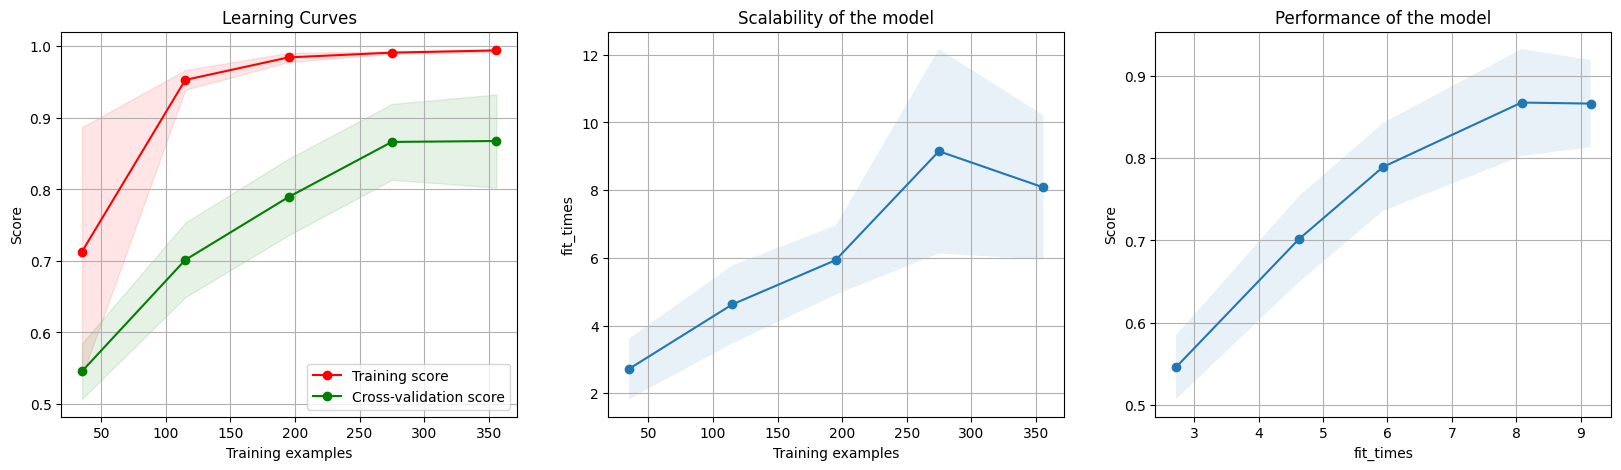

In [ ]:
#Plotting learning curves
%%time
plot_learning_curve(randomsearchCV_classifier_1, 'Learning Curves',
                    X_train_cleaned_bow, y_train, n_jobs=-1)

In [ ]:
# let's check the train scores
print(best_estimator_pipeline1_round1.score(X_train_cleaned_bow, y_train))

# let's check the cross validation score
print(complete_grid_pipeline1_round1.best_score_)

0.9955056179775281
0.9148351648351648


In [ ]:
# Final Pipeline
def final_pipeline(text):
    # cleaned_text = cp.SpacyPreprocessor(model='en_core_web_sm').transform(text)
    cleaned_text = joblib.load(file_X_test_cleaned_bow)
    best_estimator_pipeline1_round1 = joblib.load(
        file_best_estimator_pipeline1_round1)
    predictions = best_estimator_pipeline1_round1.predict(cleaned_text)
    return predictions

In [ ]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

In [ ]:
#Classification report on test data
print('\nTest set classification report:\n\n',
      classification_report(y_test, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.95      0.98      0.96        97
           1       0.83      0.67      0.74        15

    accuracy                           0.94       112
   macro avg       0.89      0.82      0.85       112
weighted avg       0.93      0.94      0.93       112



ROC AUC Score: 0.8230240549828177


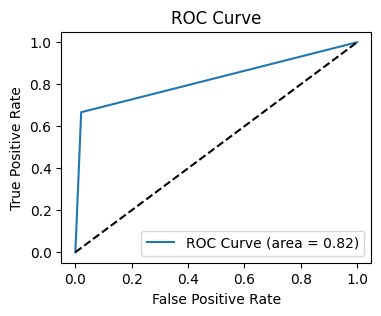

In [ ]:
#Printing ROC score results

roc_auc = roc_auc_score(y_test, y_test_pred)
print(f"ROC AUC Score: {roc_auc}")

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Approach 2: Feature Engineering

In [ ]:
# Cleaning the text data in X_train and X_test
X_train_cleaned_basic = cp.SpacyPreprocessor(model='en_core_web_sm',
                                             lemmatize=False, lower=False,
                                             remove_stop=False, remove_punct=False,
                                             remove_email=False, remove_url=False,
                                             add_user_mention_prefix=False,
                                             basic_clean_only=True).transform(X_train)

X_test_cleaned_basic = cp.SpacyPreprocessor(model='en_core_web_sm',
                                            lemmatize=False, lower=False,
                                            remove_stop=False, remove_punct=False,
                                            remove_email=False, remove_url=False,
                                            add_user_mention_prefix=False,
                                            basic_clean_only=True).transform(X_test)

# save  this to a file
file_X_train_cleaned_basic = data_folder / 'x_train_cleaned_basic_small.pkl'
joblib.dump(X_train_cleaned_basic, file_X_train_cleaned_basic)

# save  this to a file
file_X_test_cleaned_basic = data_folder / 'x_test_cleaned_basic_small.pkl'
joblib.dump(X_test_cleaned_basic, file_X_test_cleaned_basic)

/content/CustomPreprocessorSpacy.py:83: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


['datasets/x_test_cleaned_basic_small.pkl']

In [ ]:
#Using Manual Features
featurizer = ManualFeatures(spacy_model='en_core_web_sm', batch_size = 100)
X_train_cleaned_basic = joblib.load(file_X_train_cleaned_basic)
X_train_features, feature_names = featurizer.fit_transform(X_train_cleaned_basic)

In [ ]:
pd.DataFrame(X_train_features, columns=feature_names).head()

,count_words,count_characters,count_characters_no_space,avg_word_length,count_numbers,count_sentences,noun_count,aux_count,verb_count,adj_count,ner
0,10.0,49.0,40.0,3.636364,0.0,1.0,1.0,1.0,2.0,0.0,0.0
1,46.0,220.0,180.0,3.829787,0.0,1.0,6.0,2.0,11.0,3.0,0.0
2,19.0,84.0,66.0,3.300000,0.0,1.0,3.0,3.0,3.0,1.0,1.0
3,8.0,40.0,33.0,3.666667,0.0,1.0,2.0,0.0,3.0,0.0,0.0
4,8.0,26.0,19.0,2.111111,0.0,1.0,0.0,1.0,1.0,0.0,0.0


In [ ]:
#Define classifier and param grid
classifier_2 = Pipeline([('classifier', XGBClassifier())])
params_classifier_2 = {'classifier__n_estimators': [100, 200, 300],
                       'classifier__max_depth': [3, 4, 5]}

In [ ]:
#Define Random Search CV Classifier
randomsearchCV_classifier_2 = RandomizedSearchCV(estimator=classifier_2, param_distributions=params_classifier_2, cv=5, scoring='roc_auc')

In [ ]:
#Fit on train data
randomsearchCV_classifier_2.fit(X_train_features, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            grow_policy=None,
                                                            importance_type=None,
                                                            interaction_...
                                                            max_cat_threshold=None,
                                                            max_cat_to_onehot=None,
                                                            max_delta_step=None,
                                                            max_depth=None,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=None, ...))]),
                   param_distributions={'classifier__max_depth': [3, 4, 5],
                                        'classifier__n_estimators': [100, 200,
                                                                     300]},
                   scoring='roc_auc')

In [ ]:
##Validation best scores,parameters and estimators
print(f'Best cross-validation score: {randomsearchCV_classifier_2.best_score_:.2f}')
print("\nBest parameters: ", randomsearchCV_classifier_2.best_params_)
print("\nBest estimator: ", randomsearchCV_classifier_2.best_estimator_)

Best cross-validation score: 0.97

Best parameters:  {'classifier__n_estimators': 300, 'classifier__max_depth': 3}

Best estimator:  Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, miss

In [ ]:
file_best_estimator_pipeline2_round1 = model_folder / \
    'pipeline2_round1_best_estimator.pkl'
file_complete_grid_pipeline2_round1 = model_folder / \
    'pipeline2_round1_complete_grid.pkl'

joblib.dump(randomsearchCV_classifier_2.best_estimator_,
            file_best_estimator_pipeline2_round1)
joblib.dump(randomsearchCV_classifier_2, file_complete_grid_pipeline2_round1)

# load the saved model
best_estimator_pipeline2_round1 = joblib.load(file_best_estimator_pipeline2_round1)
complete_grid_pipeline2_round1 = joblib.load(file_complete_grid_pipeline2_round1)

CPU times: user 187 ms, sys: 61.6 ms, total: 249 ms
Wall time: 3.28 s


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

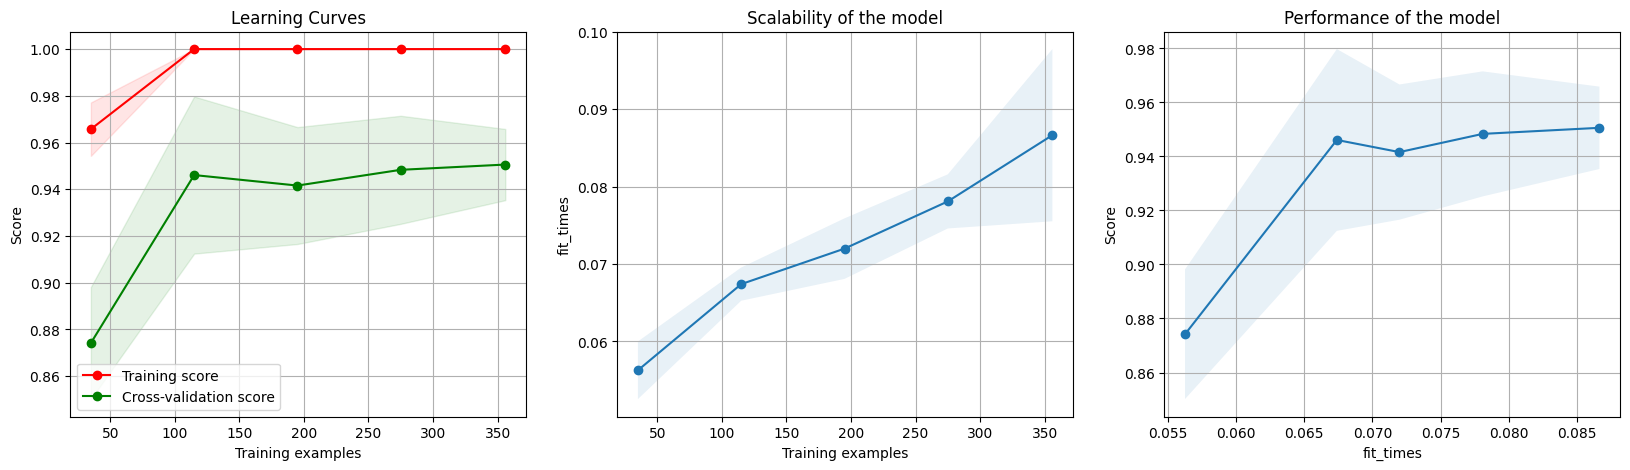

In [ ]:
#Learning curves for model 2
%%time
plot_learning_curve(best_estimator_pipeline2_round1, 'Learning Curves',
                    X_train_features, y_train, n_jobs=-1)

In [ ]:
# let's check the train scores
print(best_estimator_pipeline2_round1.score(X_train_features, y_train))

# let's check the cross validation score
print(complete_grid_pipeline2_round1.best_score_)

1.0
0.9716949716949717


In [ ]:
best_estimator_pipeline2_round1

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
# Final Pipeline
def final_pipeline(text):
    text_cleaned = joblib.load(file_X_test_cleaned_basic)
    features, feature_names = featurizer.fit_transform(text_cleaned)
    best_estimator_pipeline2_round1 = joblib.load(
        file_best_estimator_pipeline2_round1)
    predictions = best_estimator_pipeline2_round1.predict(features)
    return predictions

In [ ]:
y_test_pred = final_pipeline(X_test)

In [ ]:
#Classification report on test data
print('\nTest set classification report:\n\n', classification_report(y_test, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.98      0.96      0.97        97
           1       0.76      0.87      0.81        15

    accuracy                           0.95       112
   macro avg       0.87      0.91      0.89       112
weighted avg       0.95      0.95      0.95       112



ROC AUC Score: 0.9127147766323025


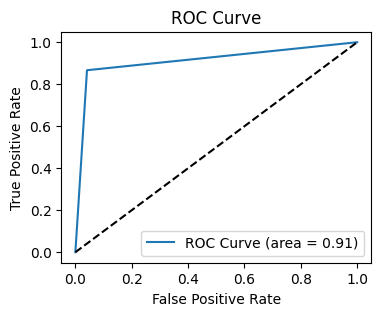

In [ ]:
##Printing ROC score results

roc_auc = roc_auc_score(y_test, y_test_pred)
print(f"ROC AUC Score: {roc_auc}")

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Approach 3: Sparse Embeddings (TF-IDF) + Feature Engineering

In [ ]:
X_train_cleaned_bow = joblib.load(file_X_train_cleaned_bow)
X_train_final = pd.concat((pd.DataFrame(X_train_cleaned_bow, columns=['cleaned_text']),
                           pd.DataFrame(X_train_features, columns=feature_names)), axis=1)

X_train_final.head(2)

,cleaned_text,count_words,count_characters,count_characters_no_space,avg_word_length,count_numbers,count_sentences,noun_count,aux_count,verb_count,adj_count,ner
0,pick drop car.so problem ..,10.0,49.0,40.0,3.636364,0.0,1.0,1.0,1.0,2.0,0.0,0.0
1,pattern emerge friend tell drive come smoke te...,46.0,220.0,180.0,3.829787,0.0,1.0,6.0,2.0,11.0,3.0,0.0


In [ ]:
#Transformer class
class SparseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return csr_matrix(X)

In [ ]:
#Putting Sparse features and vectorizer in pipeline
sparse_features = Pipeline([('sparse', SparseTransformer()), ])
vectorizer = Pipeline([('tfidf', TfidfVectorizer(max_features=5)), ])

In [ ]:
combined_features = ColumnTransformer(
    transformers=[
        ('tfidf', vectorizer, 'cleaned_text'),
    ], remainder=sparse_features
)

In [ ]:
#Defining classifier
classifier_3 = Pipeline([('combined_features',  combined_features),
                         ('classifier', XGBClassifier())])

In [ ]:
#Defining param grid
params_classifier_3 = {'combined_features__tfidf__tfidf__max_features': [500, 1000, 1500, 2000],
                       'combined_features__tfidf__tfidf__min_df': [1, 2, 3],
                       'combined_features__tfidf__tfidf__max_df': [0.5, 0.75, 1.0],
                       'combined_features__tfidf__tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
                       'classifier__n_estimators': [100, 200, 300],
                       'classifier__max_depth': [3, 4, 5]
                       }

In [ ]:
##Define Random Search CV Classifier
randomsearchCV_classifier_3 = RandomizedSearchCV(estimator=classifier_3, param_distributions=params_classifier_3, cv=5, scoring='roc_auc')

In [ ]:
##Fit on train data
randomsearchCV_classifier_3.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('combined_features',
                                              ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                           SparseTransformer())]),
                                                                transformers=[('tfidf',
                                                                               Pipeline(steps=[('tfidf',
                                                                                                TfidfVectorizer(max_features=5))]),
                                                                               'cleaned_text')])),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsa...
                   param_distributions={'classifier__max_depth': [3, 4, 5],
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'combined_features__tfidf__tfidf__max_df': [0.5,
                                                                                    0.75,
                                                                                    1.0],
                                        'combined_features__tfidf__tfidf__max_features': [500,
                                                                                          1000,
                                                                                          1500,
                                                                                          2000],
                                        'combined_features__tfidf__tfidf__min_df': [1,
                                                                                    2,
                                                                                    3],
                                        'combined_features__tfidf__tfidf__ngram_range': [(1,
                                                                                          1),
                                                                                         (1,
                                                                                          2),
                                                                                         (2,
                                                                                          2)]},
                   scoring='roc_auc')

In [ ]:
#Printing cross valdiation report
print("Best cross-validation score: {:.2f}".format(randomsearchCV_classifier_3.best_score_))
print("\nBest parameters: ", randomsearchCV_classifier_3.best_params_)
print("\nBest estimator: ", randomsearchCV_classifier_3.best_estimator_)

Best cross-validation score: 0.97

Best parameters:  {'combined_features__tfidf__tfidf__ngram_range': (1, 1), 'combined_features__tfidf__tfidf__min_df': 1, 'combined_features__tfidf__tfidf__max_features': 1000, 'combined_features__tfidf__tfidf__max_df': 1.0, 'classifier__n_estimators': 200, 'classifier__max_depth': 5}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=1000))]),
                                                  'cleaned_text')])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylev

In [ ]:
file_best_estimator_pipeline3_round1 = model_folder / \
    'pipeline3_round1_best_estimator.pkl'
file_complete_grid_pipeline3_round1 = model_folder / \
    'pipeline3_round1_complete_grid.pkl'

joblib.dump(randomsearchCV_classifier_3.best_estimator_, file_best_estimator_pipeline3_round1)
joblib.dump(randomsearchCV_classifier_3, file_complete_grid_pipeline3_round1)

# load the saved model
best_estimator_pipeline3_round1 = joblib.load(file_best_estimator_pipeline3_round1)
complete_grid_pipeline3_round1 = joblib.load(file_complete_grid_pipeline3_round1)

CPU times: user 230 ms, sys: 10.7 ms, total: 241 ms
Wall time: 2.84 s


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

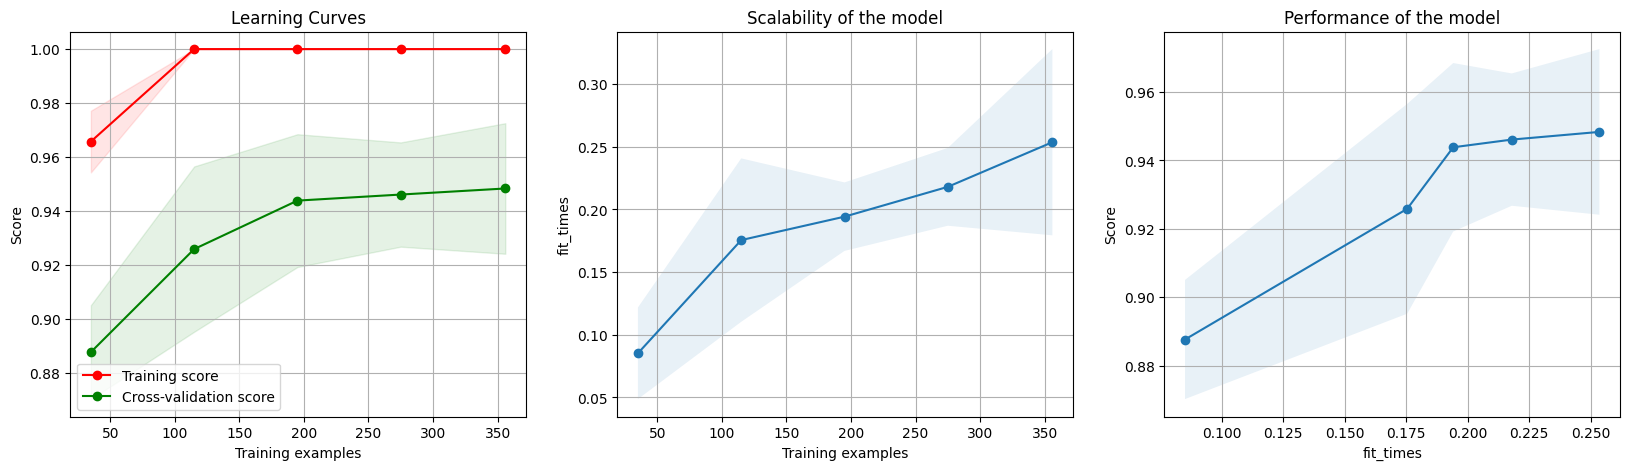

In [ ]:
#learning curve for model 3
%%time
plot_learning_curve(best_estimator_pipeline3_round1, 'Learning Curves',
                    X_train_final, y_train, n_jobs=-1)

In [ ]:
# let's check the train scores
print(best_estimator_pipeline3_round1.score(X_train_final, y_train))

# let's check the cross validation score
print(complete_grid_pipeline3_round1.best_score_)

1.0
0.9727938727938727


In [ ]:
# Final Pipeline
def final_pipeline(text):
    # cleaned_text = cp.SpacyPreprocessor(model='en_core_web_sm', batch_size = 1000).transform(text)
    cleaned_text = joblib.load(file_X_test_cleaned_bow)
    X_features, feature_names = featurizer.fit_transform(text)
    X_final = pd.concat((pd.DataFrame(cleaned_text, columns=['cleaned_text']),
                         pd.DataFrame(X_features, columns=feature_names)), axis=1)
    best_estimator_pipeline3_round1 = joblib.load(
        file_best_estimator_pipeline3_round1)
    predictions = best_estimator_pipeline3_round1.predict(X_final)
    return predictions

In [ ]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

In [ ]:
#Classification report on test data
print('\nTest set classification report:\n\n',
      classification_report(y_test, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.98      0.95      0.96        97
           1       0.72      0.87      0.79        15

    accuracy                           0.94       112
   macro avg       0.85      0.91      0.88       112
weighted avg       0.94      0.94      0.94       112



ROC AUC Score: 0.9075601374570447


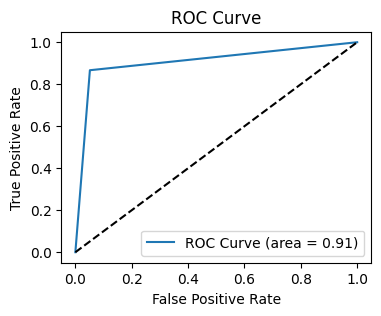

In [ ]:
#ROC Score on model 3
roc_auc = roc_auc_score(y_test, y_test_pred)
print(f"ROC AUC Score: {roc_auc}")

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Running the best pipeline on 40% sampled data

# **Required Submissions:**
1.  Submit two colab/jupyter notebooks
- (analysis with smaller subset and all three pipelines)
- (analysis with bigger subset and only final pipeline)
2. Pdf version of the notebooks (HWs will not be graded if pdf version is not provided.
3. **The notebooks and pdf files should have the output.**
4. **Name files as follows : FirstName_file1_hw2, FirstName_file2_h2**